In [4]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import krippendorff
import scipy
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import importlib, os
import sklearn

current_dir = os.getcwd()
%cd ..
import textmining
from textmining import text_miner
importlib.reload(textmining.text_miner)
os.chdir(current_dir)


%matplotlib inline

sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(4,2)}, 
    style="white" # nicer layout
)

C:\Users\elba_ro\Documents\dlr_projects\repository-synergy\code


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elba_ro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Get Results 

In [5]:
eval_root = '../../data/evaluation/manual/results'

annotations= '{}/reposynergy.annotation.csv'.format(eval_root)
repo_pairs = '{}/repositorypiar_with_bert_uncased.csv'.format(eval_root)#'{}/reposynergy.repositorypair.csv'.format(eval_root)
repo_pairs_scores = '{}/repositorypair_score_with_bert_uncased_score.csv'.format(eval_root)#'{}/reposynergy.repositorypair_scores.csv'.format(eval_root)
users      = '{}/reposynergy.user.csv'.format(eval_root)

In [6]:
# remove dummy annotations
batch1_user_ids = [8, 12, 10]
batch2_user_ids = [11,13,15]
batch3_user_ids = [19, 16, 20] 
#[(19, 16, 20), (19, 16, 14), (19, 20, 14), (16, 20, 14)]
valid_users= batch1_user_ids +batch2_user_ids +batch3_user_ids


In [7]:
# get all data: annotations, pairs, and pair scores
annotations_df= pd.read_csv(annotations)
annotations_df = annotations_df[annotations_df['user_id'].isin(valid_users)].copy()

repo_pairs_df = pd.read_csv(repo_pairs)
repo_pairs_df.set_index('id', inplace=True)
repo_pairs_scores_df = pd.read_csv(repo_pairs_scores)


users_df      = pd.read_csv(users)
users_df.set_index('id', inplace=True)



In [8]:
# Add mapped synergy
def _synergy_map(row):
    map_syn = {1:-1, 2:0, 3:1, 4:2}
    row['synergy_map'] = map_syn[row['synergy']]
    return row

def _abstract_synergy_map(row):
    map_syn = {1:0, 2:1, 3:2, 4:2}
    row['synergy_abstract'] = map_syn[row['synergy']]
    return row

def _yn_synergy_map(row):
    map_syn = {1:0, 2:1, 3:1, 4:1}
    row['synergy_yn'] = map_syn[row['synergy']]
    return row
annotations_df=annotations_df.apply(_synergy_map, axis=1)
annotations_df=annotations_df.apply(_abstract_synergy_map, axis=1)
annotations_df=annotations_df.apply(_yn_synergy_map, axis=1)

In [126]:
# Get Jaccard Score for each pair
def get_repo_readme(url):
    folder = "../../data/readme_files"
    path = '{}/{}.md'.format(folder, '.'.join(url.split('/')[-2:]))
    data = None#

    with open(path, 'r', encoding="utf8") as file:
        data = file.read()

    return data

def jaccard_similarity(text1, text2):
    intersection = set(text1).intersection(set(text2))
    union = set(text1).union(set(text2))
    return len(intersection)/len(union)

def _get_jaccard_sim(row):
    readme1 = get_repo_readme(row["repo_url1"])
    readme2 = get_repo_readme(row["repo_url2"])
    
    readme1 = text_miner.preprocess(readme1, stem_lemma=2)['lemmas']
    readme2 = text_miner.preprocess(readme2, stem_lemma=2)['lemmas']
    
    row['jaccard'] =  jaccard_similarity(readme1, readme2)
    return row
repo_pairs_scores_df = repo_pairs_scores_df.apply(_get_jaccard_sim, axis=1)
repo_pairs_df = repo_pairs_df.apply(_get_jaccard_sim, axis=1)

In [9]:
def join_all_dfs(df):
    ann_df = df.copy()
    ann_df['repopair_id'] = ann_df['repository_pair_id']
    ann_df['u_id'] = ann_df['user_id']
    
    
    ann_df = ann_df.set_index('repopair_id').join(repo_pairs_df, how='inner', lsuffix='repopair_').copy()
    ann_df = ann_df.set_index('u_id').join(users_df, how='inner', lsuffix='users_')
    return ann_df
data_df = join_all_dfs(annotations_df)
data_df = data_df[data_df['user_id'].isin(valid_users)].copy()

In [10]:
data_df[['algorithm', 'synergy']]

,algorithm,synergy
8,random,1
8,d02,1
8,random,1
8,random,3
8,d02,1
...,...,...
20,d00,3
20,d02,4
20,d00,4
20,d00,1


# 1. Interannotator agreement

In [129]:
batch1_annotations = annotations_df[annotations_df['user_id'].isin(batch1_user_ids)].copy()
batch2_annotations = annotations_df[annotations_df['user_id'].isin(batch2_user_ids)].copy()
batch3_annotations = annotations_df[annotations_df['user_id'].isin(batch3_user_ids)].copy()

d00_annotations = data_df[data_df['algorithm'] == 'd00'].copy()
d02_annotations = data_df[data_df['algorithm'] == 'd02'].copy()
random_annotations = data_df[data_df['algorithm'] == 'random'].copy()

print(len(batch1_annotations))
print(len(batch2_annotations))
print(len(batch3_annotations))

print(len(d00_annotations))
print(len(d02_annotations))
print(len(random_annotations))

90
90
90
90
90
90


In [130]:
save_cols = ['a_id', 'user_id', 'repository_pair_id', 'synergy',
       'direction', 'explanation', 'synergy_map', 'synergy_abstract', 'repo_description1',
       'repo_description2', 'score', 'username', 'batch']

In [131]:
d00_annotations[save_cols].sort_values('repository_pair_id').to_csv('{}/d00_evaluation.csv'.format(eval_root))
d02_annotations[save_cols].sort_values('repository_pair_id').to_csv('{}/d02_evaluation.csv'.format(eval_root))
random_annotations[save_cols].sort_values('repository_pair_id').to_csv('{}/random_evaluation.csv'.format(eval_root))

In [132]:
# helper 
def pad_2d_array(lst):
    pad = len(max(lst, key=len))
    return np.array([i + [0]*(pad-len(i)) for i in lst])

def _get_value_counts(df, var = 'synergy'):
    synergy_value_counts = [] # this array will contain X arrays where X is the number of articles.
                           # each x contains N elements where N is the number of distinct theses selected by annotators
                           # each element is the count of annotators that selected a speicifc thesis

    for repo_pair_id, group in df.groupby(['repository_pair_id']): # for each article, we will have 1 array, X

        synergy_list = group[var].tolist() # 5 theses , a thesis can be 2 segments

        value_counts = list(Counter(synergy_list).values())
        synergy_value_counts.append(value_counts)
        
    return synergy_value_counts

def calculate_kripp_agreement(df, var='synergy'):
    synergy_value_counts = _get_value_counts(df, var=var)
    padded = pad_2d_array(synergy_value_counts)
    
    agreement = krippendorff.alpha(value_counts=padded, level_of_measurement='nominal')
    return agreement

def calculate_majority_agreement(df, threshold= 2, var='synergy'):
    synergy_value_counts = _get_value_counts(df, var=var)

    maxes = [max(x) for x in synergy_value_counts]
    maj = round(((sum(i >= threshold for i in maxes))/len(synergy_value_counts)), 2)
    return maj

print('Krippendorf\'s')
print('Batch 1:' , calculate_kripp_agreement(batch1_annotations, var='synergy'))
print('Batch 2:' , calculate_kripp_agreement(batch2_annotations, var='synergy'))
print('Batch 3:' , calculate_kripp_agreement(batch3_annotations, var='synergy'))
print('all annotations: ', calculate_kripp_agreement(annotations_df, var='synergy'))
print()
print('MAJORITY')
print('Batch 1:' , calculate_majority_agreement(batch1_annotations))
print('Batch 2:' , calculate_majority_agreement(batch2_annotations))
print('Batch 3:' , calculate_majority_agreement(batch3_annotations))
print('all annotations: ', calculate_majority_agreement(annotations_df))
print()
print('FULL')
print('Batch 1: ', calculate_majority_agreement(batch1_annotations, threshold=3))
print('Batch 2: ', calculate_majority_agreement(batch2_annotations, threshold=3))
print('Batch 3: ', calculate_majority_agreement(batch3_annotations, threshold=3))
print('all annotations: ', calculate_majority_agreement(annotations_df, threshold=3))

Krippendorf's
Batch 1: 0.02516281823564248
Batch 2: -0.19049815498154987
Batch 3: -0.025233132199670827
all annotations:  -0.07324247189702371

MAJORITY
Batch 1: 0.97
Batch 2: 0.73
Batch 3: 0.93
all annotations:  0.88

FULL
Batch 1:  0.4
Batch 2:  0.17
Batch 3:  0.33
all annotations:  0.3


In [170]:
d00_annotations.columns

Index(['a_id', 'user_id', 'repository_pair_id', 'annotation_date', 'synergy',
       'direction', 'explanation', 'synergy_map', 'synergy_abstract',
       'synergy_yn', 'repo_url1', 'repo_url2', 'repo_description1',
       'repo_description2', 'score', 'is_random', 'algorithm', 'batchusers_',
       'jaccard', 'password', 'last_login', 'is_superuser', 'username',
       'first_name', 'last_name', 'email', 'is_staff', 'is_active',
       'date_joined', 'batch'],
      dtype='object')

In [174]:

print('Krippendorf\'s')
print('d00:' , calculate_kripp_agreement(d00_annotations, var='synergy_abstract'))
print('d02:' , calculate_kripp_agreement(d02_annotations, var='synergy_abstract'))
print('random:' , calculate_kripp_agreement(random_annotations, var='synergy_abstract'))
print('all annotations: ', calculate_kripp_agreement(annotations_df, var='synergy_abstract'))
print()
print('Krippendorf\'s yes no')
print('d00:' , calculate_kripp_agreement(d00_annotations, var='synergy_yn'))
print('d02:' , calculate_kripp_agreement(d02_annotations, var='synergy_yn'))
print('random:' , calculate_kripp_agreement(random_annotations, var='synergy_yn'))
print('all annotations: ', calculate_kripp_agreement(annotations_df, var='synergy_yn'))
print()
print('MAJORITY')
print('d00:' , calculate_majority_agreement(d00_annotations))
print('d02:' , calculate_majority_agreement(d02_annotations))
print('random:' , calculate_majority_agreement(random_annotations))
print('all annotations: ', calculate_majority_agreement(annotations_df))
print()
print('FULL')
print('d00: ', calculate_majority_agreement(d00_annotations, threshold=3))
print('d02: ', calculate_majority_agreement(d02_annotations, threshold=3))
print('Brandom: ', calculate_majority_agreement(random_annotations, threshold=3))
print('all annotations: ', calculate_majority_agreement(annotations_df, threshold=3))

print()
print('MAJORITY yes no')
print('d00:' , calculate_majority_agreement(d00_annotations, var='synergy_yn'))
print('d02:' , calculate_majority_agreement(d02_annotations, var='synergy_yn'))
print('random:' , calculate_majority_agreement(random_annotations, var='synergy_yn'))
print('all annotations: ', calculate_majority_agreement(annotations_df, var='synergy_yn'))
print()
print('FULL yes no')
print('d00: ', calculate_majority_agreement(d00_annotations, threshold=3, var='synergy_yn'))
print('d02: ', calculate_majority_agreement(d02_annotations, threshold=3, var='synergy_yn'))
print('random: ', calculate_majority_agreement(random_annotations, threshold=3, var='synergy_yn'))
print('all annotations: ', calculate_majority_agreement(annotations_df, threshold=3, var='synergy_yn'))




print()
print('d00: ', calculate_majority_agreement(d00_annotations, threshold=2, var='direction'))
print('d02: ', calculate_majority_agreement(d02_annotations, threshold=2, var='direction'))
print('random: ', calculate_majority_agreement(random_annotations, threshold=2, var='direction'))
print('all annotations: ', calculate_majority_agreement(annotations_df, threshold=2, var='direction'))

print()
print('d00: ', calculate_majority_agreement(d00_annotations, threshold=3, var='direction'))
print('d02: ', calculate_majority_agreement(d02_annotations, threshold=3, var='direction'))
print('random: ', calculate_majority_agreement(random_annotations, threshold=3, var='direction'))
print('all annotations: ', calculate_majority_agreement(annotations_df, threshold=3, var='direction'))

Krippendorf's
d00: 0.04761904761904767
d02: -0.09486057955166749
random: 0.19143413367942896
all annotations:  -0.0065898403867805655

Krippendorf's yes no
d00: 0.07867494824016552
d02: 0.10725308641975306
random: 0.22660427807486627
all annotations:  0.0796895861148198

MAJORITY
d00: 0.8
d02: 0.83
random: 1.0
all annotations:  0.88

FULL
d00:  0.2
d02:  0.2
Brandom:  0.5
all annotations:  0.3

MAJORITY yes no
d00: 1.0
d02: 1.0
random: 1.0
all annotations:  1.0

FULL yes no
d00:  0.5
d02:  0.57
random:  0.57
all annotations:  0.54

d00:  0.8
d02:  0.87
random:  1.0
all annotations:  0.89

d00:  0.17
d02:  0.3
random:  0.5
all annotations:  0.32


# 2. df for each algorithm / Significance Tests

## DATA as it is

In [11]:
# ALGORITHMS
#data_df = join_all_dfs(annotations_df)
print(len(data_df))
algorithms = data_df['algorithm'].unique()
data_df.columns

270


Index(['a_id', 'user_id', 'repository_pair_id', 'annotation_date', 'synergy',
       'direction', 'explanation', 'synergy_map', 'synergy_abstract',
       'synergy_yn', 'repo_url1', 'repo_url2', 'repo_description1',
       'repo_description2', 'score', 'is_random', 'algorithm', 'batchusers_',
       'bert_uncased_sim', 'password', 'last_login', 'is_superuser',
       'username', 'first_name', 'last_name', 'email', 'is_staff', 'is_active',
       'date_joined', 'batch'],
      dtype='object')

In [135]:
pd.crosstab(data_df.algorithm, data_df.synergy_map,margins=True)

synergy_map,-1,0,1,2,All
algorithm,,,,,
d00,31,12,25,22,90
d02,38,15,25,12,90
random,69,6,11,4,90
All,138,33,61,38,270


In [136]:
pd.crosstab(data_df.algorithm, data_df.synergy_abstract,margins=True)

synergy_abstract,0,1,2,All
algorithm,,,,
d00,31,12,47,90
d02,38,15,37,90
random,69,6,15,90
All,138,33,99,270


In [137]:
pd.crosstab(data_df.algorithm, data_df.synergy_yn,margins=True)

synergy_yn,0,1,All
algorithm,,,
d00,31,59,90
d02,38,52,90
random,69,21,90
All,138,132,270


In [138]:
random_df =  data_df[data_df['algorithm'] == 'random' ]
d02_df =  data_df[data_df['algorithm'] == 'd02' ]
d00_df =  data_df[data_df['algorithm'] == 'd00' ]

In [139]:
print('random: ', round(random_df['synergy_map'].mean(), 2))
print('d02: ', round(d02_df['synergy_map'].mean(), 2))
print('d00: ', round(d00_df['synergy_map'].mean(), 2))

print('random: ', round(random_df['synergy'].mean(), 2))
print('d02: ', round(d02_df['synergy'].mean(), 2))
print('d00: ', round(d00_df['synergy'].mean(), 2))

random:  -0.56
d02:  0.12
d00:  0.42
random:  1.44
d02:  2.12
d00:  2.42


In [140]:
random_df['synergy'].describe()

count    90.000000
mean      1.444444
std       0.875524
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       4.000000
Name: synergy, dtype: float64

In [141]:
d00_df['synergy'].describe()

count    90.000000
mean      2.422222
std       1.199042
min       1.000000
25%       1.000000
50%       3.000000
75%       3.000000
max       4.000000
Name: synergy, dtype: float64

In [142]:
d02_df['synergy'].describe()

count    90.000000
mean      2.122222
std       1.109993
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: synergy, dtype: float64

In [143]:
data_df.columns#[['algorithm', 'synergy']]

Index(['a_id', 'user_id', 'repository_pair_id', 'annotation_date', 'synergy',
       'direction', 'explanation', 'synergy_map', 'synergy_abstract',
       'synergy_yn', 'repo_url1', 'repo_url2', 'repo_description1',
       'repo_description2', 'score', 'is_random', 'algorithm', 'batchusers_',
       'jaccard', 'password', 'last_login', 'is_superuser', 'username',
       'first_name', 'last_name', 'email', 'is_staff', 'is_active',
       'date_joined', 'batch'],
      dtype='object')

In [144]:
from textmining import significance_testing as st
significance = st.significance(data_df, features = ['synergy'], save=True, desc='significance_evaluations',independent_var='algorithm' )
significance


data has 270 instances
bonforrini_threshold:  0.016666666666666666


,random d02,random d00,d02 d00
feature,,,
synergy,-0.3,-0.39,NaN


In [145]:
data_df.columns

Index(['a_id', 'user_id', 'repository_pair_id', 'annotation_date', 'synergy',
       'direction', 'explanation', 'synergy_map', 'synergy_abstract',
       'synergy_yn', 'repo_url1', 'repo_url2', 'repo_description1',
       'repo_description2', 'score', 'is_random', 'algorithm', 'batchusers_',
       'jaccard', 'password', 'last_login', 'is_superuser', 'username',
       'first_name', 'last_name', 'email', 'is_staff', 'is_active',
       'date_joined', 'batch'],
      dtype='object')

In [12]:
data_df['bert_scaled'] = sklearn.preprocessing.minmax_scale(data_df['bert_uncased_sim'] , feature_range=(1, 4),  axis=0, copy=True)
#data_df['score_scaled'] = sklearn.preprocessing.minmax_scale(data_df['jaccard'] , feature_range=(1, 4),  axis=0, copy=True)

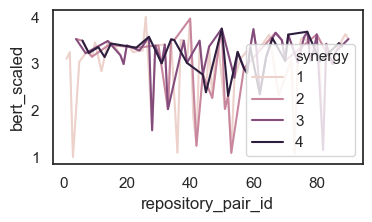

In [13]:
sns.lineplot('repository_pair_id', 'bert_scaled', hue="synergy", data=data_df, sort=True)
plt.show()

In [148]:

repo_pairs_scores_df.columns
#sns.boxplot('algorithm', 'score_scaled', hue="synergy", data=data_df)
#plt.show()


Index(['Unnamed: 0', 'id', 'repo_url1', 'repo_url2', 'repo_description1',
       'repo_description2', 'score', 'is_random', 'algorithm', 'batch',
       'score_nmf_mult', 'score_nmf_rwr_d00', 'score_nmf_rwr_d01',
       'score_nmf_rwr_d02', 'score_nmf_rwr_d03', 'score_nmf_rwr_d05',
       'score_lda_rwr_d00', 'score_lda_rwr_d01', 'score_lda_rwr_d02',
       'score_lda_rwr_d03', 'score_lda_rwr_d05', 'jaccard'],
      dtype='object')

## DATA majority

In [14]:
def _add_majority_annotations(row, annotations):
    #synergy_map = {1: -1, 2: 0, 3: 1, 4: 2}
    direction_map = {0: 'None', 12: 'repo1 can benefit from repo2', 21: 'repo2 can benefit from repo1',
                     2: 'both can benefit from each others'}

    repo_id = row.id

    repo_annotations = annotations[annotations['repository_pair_id'] == repo_id].copy()  

    if (repo_annotations) is not None :
        annotations = [x for x in   list(repo_annotations['synergy'].values)]
        directions = [x for x in   list(repo_annotations['direction'].values)]
        
        row['synergy_majority'] = max(annotations,key=annotations.count)
        
        row['has_majority'] = True if max(Counter(annotations).values()) >=2 else False
        
        row['direction_majority'] = max(directions,key=annotations.count) if  max(Counter(directions).values()) >=2 else 2
        row['has_majority_direction'] = True if max(Counter(directions).values()) >=2 else False
        row['directions'] = directions
        
        row['synergy_avg'] = round(np.mean(annotations))

    return row

In [15]:
repo_pairs_ann_df = repo_pairs_scores_df.apply(_add_majority_annotations, axis=1, args=(data_df,))
repo_pairs_ann_df.head()
repo_pairs_ann_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [16]:
print(repo_pairs_ann_df.has_majority_direction.value_counts())
print(repo_pairs_ann_df.has_majority.value_counts())


True     80
False    10
Name: has_majority_direction, dtype: int64
True     79
False    11
Name: has_majority, dtype: int64


In [17]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)


temp = repo_pairs_ann_df[(repo_pairs_ann_df.has_majority == True) 
                         & (repo_pairs_ann_df.synergy_avg == 4)
                         & (repo_pairs_ann_df.algorithm == 'd00')
                         & (repo_pairs_ann_df.has_majority_direction == True)][['repo_description1', 
                                                                        'repo_description2'  ,
                                                                       'algorithm', 'direction_majority', 
                                                                               'synergy_majority']].copy()
#print(temp.to_latex(index=False))  

temp

,repo_description1,repo_description2,algorithm,direction_majority,synergy_majority
10,Flexible and scalable Django authorization backend for unified per object permission management,"Core common behaviors for Django models, e.g. Timestamps, Publishing, Authoring, Editing and more.",d00,2,4
54,Restricted Boltzmann Machines in Python.,ETH Robustness Analyzer for Deep Neural Networks,d00,2,4
65,"PiCheckVoltage is a project for the Raspberry Pi intended to provide a mean to check voltage of a battery pack which is used to power electronic assemblies connected to the Raspberry Pi, and execute scripts depending on battery level.",balena-sense,d00,21,4
76,"✍️ An intelligent system that takes a single document and classifies different writing styles within the document using stylometric analysis. The classification is done using K-Means Clustering. Moreover, a detailed description is given in Readme.md. The",Text classification using Naive Bayes and Elasticsearch,d00,21,4
87,Python Wrapper for NVD3 - It's time for beautiful charts,Awesome React Native UI components updated daily,d00,2,4


In [153]:
repo_pairs_ann_df.columns

Index(['id', 'repo_url1', 'repo_url2', 'repo_description1',
       'repo_description2', 'score', 'is_random', 'algorithm', 'batch',
       'score_nmf_mult', 'score_nmf_rwr_d00', 'score_nmf_rwr_d01',
       'score_nmf_rwr_d02', 'score_nmf_rwr_d03', 'score_nmf_rwr_d05',
       'score_lda_rwr_d00', 'score_lda_rwr_d01', 'score_lda_rwr_d02',
       'score_lda_rwr_d03', 'score_lda_rwr_d05', 'jaccard', 'synergy_majority',
       'has_majority', 'direction_majority', 'has_majority_direction',
       'directions', 'synergy_avg'],
      dtype='object')

In [18]:
repo_pairs_ann_df['score_bert_scaled'] = sklearn.preprocessing.minmax_scale(repo_pairs_ann_df['bert_uncased_sim'] , feature_range=(1, 4),  axis=0, copy=True)
repo_pairs_ann_df['score_lda_rwr_d00_scaled'] = sklearn.preprocessing.minmax_scale(repo_pairs_ann_df['score_lda_rwr_d00'] , feature_range=(1, 4),  axis=0, copy=True)
repo_pairs_ann_df['score_lda_rwr_d02_scaled'] = sklearn.preprocessing.minmax_scale(repo_pairs_ann_df['score_lda_rwr_d02'] , feature_range=(1, 4),  axis=0, copy=True)




In [19]:
repo_pairs_ann_df.head()

,Unnamed: 0.1,id,repo_url1,repo_url2,repo_description1,repo_description2,score,is_random,algorithm,batch,...,bert_uncased_sim,synergy_majority,has_majority,direction_majority,has_majority_direction,directions,synergy_avg,score_bert_scaled,score_lda_rwr_d00_scaled,score_lda_rwr_d02_scaled
0,0,1,https://api.github.com/repos/dashayushman/TAC-GAN,https://api.github.com/repos/entropy1337/infernal-twin,Text Conditioned Auxiliary Classifier Generative Adversarial Network,wireless hacking - This is automated wireless hacking tool,0.000000,True,random,1,...,0.772640,1,True,0,True,"[0, 0, 0]",1.0,3.103438,1.000000,1.059542
1,1,2,https://api.github.com/repos/EugenioDelfa/Smali-CFGs,https://api.github.com/repos/plinss/acmebot,Smali Control Flow Graph's,Certificate manager bot using ACME protocol,0.001523,False,d02,1,...,0.808424,1,True,0,True,"[0, 0, 0]",1.0,3.245185,3.573288,3.111039
2,2,3,https://api.github.com/repos/4pr0n/rip,https://api.github.com/repos/vzhong/embeddings,album ripper,Pretrained Embeddings,0.000000,True,random,1,...,0.241637,1,True,0,True,"[0, 0, 0]",1.0,1.000000,1.048503,1.143865
3,3,4,https://api.github.com/repos/progrium/skypipe,https://api.github.com/repos/marcy-terui/lamvery,A magic pipe in the sky for the command line,Function based deploy and management tool for AWS Lambda.,0.000000,True,random,1,...,0.879565,3,True,21,True,"[21, 12, 21]",3.0,3.526993,1.233526,1.259896
4,4,5,https://api.github.com/repos/weiweihuanghuang/Work-Sans,https://api.github.com/repos/googlei18n/corpuscrawler,A grotesque sans.,Crawler for linguistic corpora,0.001432,False,d02,1,...,0.756321,1,True,0,True,"[0, 0, 0]",1.0,3.038795,2.598521,2.886069


In [20]:
import pandas as pd
lf_repo_pairs_ann_df = repo_pairs_ann_df[['id',  'synergy_avg',
                         'score_lda_rwr_d00_scaled',
                         'score_lda_rwr_d02_scaled',
                         'score_bert_scaled']].copy()
lf_repo_pairs_ann_df = pd.wide_to_long(lf_repo_pairs_ann_df, 'score', i='id', j='algorithm',sep='_', suffix='\w+')
lf_repo_pairs_ann_df.reset_index(inplace=True)


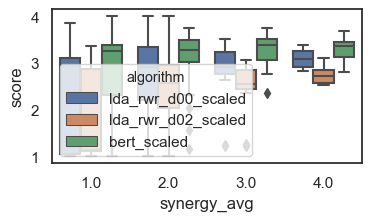

In [21]:


sns.boxplot('synergy_avg', 'score', hue='algorithm', data=lf_repo_pairs_ann_df)
plt.show()

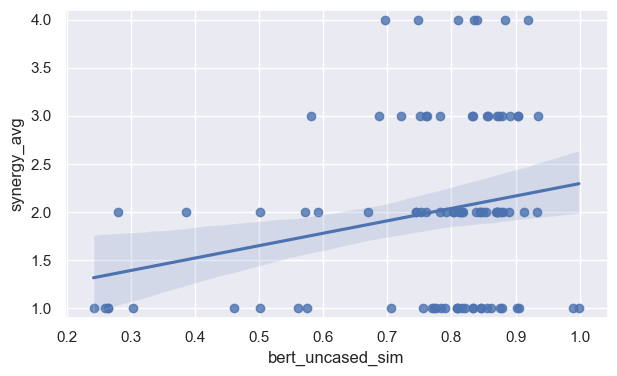

In [22]:

sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,4)}, 
    #style="white" # nicer layout
)
plt.ylim(0.9, 4.1)
sns.regplot(x="bert_uncased_sim", y="synergy_avg", data=repo_pairs_ann_df)
plt.show()

In [23]:

majority_df = repo_pairs_ann_df[repo_pairs_ann_df.has_majority == True].copy()
majority_df.has_majority.value_counts()
majority_df.has_majority_direction.value_counts()


True     74
False     5
Name: has_majority_direction, dtype: int64

## Correlations Algo vs Manual eval

In [24]:
algorithms = ['score_nmf_mult', 'score_nmf_rwr_d00', 'score_nmf_rwr_d01',
       'score_nmf_rwr_d02', 'score_nmf_rwr_d03', 'score_nmf_rwr_d05',
       'score_lda_rwr_d00', 'score_lda_rwr_d01', 'score_lda_rwr_d02',
       'score_lda_rwr_d03', 'score_lda_rwr_d05', 'bert_uncased_sim']
manual = ['synergy_avg']#['synergy_avg'] #['synergy_majority',


In [25]:

def calculate_correlations(df, alpha=0.05):

    print("Correlation between: \n")
    dv_pairs = list(itertools.product(algorithms, manual))
    
    for dv_pair in dv_pairs:
        corr, p_val = scipy.stats.spearmanr(df[dv_pair[0]], df[dv_pair[1]]) # you can use spearmanr
        if p_val < alpha:
            print('{}: is {:04.2f} with {} p_value at {} ({:f})'.format(
                 str(dv_pair), corr, 
                 'significant', 
                  alpha,
                 p_val))
        
        
    ######Format for heatmap    
    
    res= []
    for var1 in algorithms:
        row_res={}
        
        
        for var2 in manual:
            corr, p_val = scipy.stats.spearmanr(df[var1], df[var2]) #
            if p_val >= alpha:
                print(var1, var2)
            else:
                row_res['Algorithms'] = var1
                row_res[var2] = round(corr, 2)
        
        if 'Algorithms' in row_res.keys(): res.append(row_res)
    res_df = pd.DataFrame(res)
    res_df.set_index('Algorithms', inplace=True)
    
    return res_df

In [26]:
corr_df =calculate_correlations(repo_pairs_ann_df)

Correlation between: 

('score_nmf_mult', 'synergy_avg'): is 0.27 with significant p_value at 0.05 (0.010058)
('score_nmf_rwr_d00', 'synergy_avg'): is 0.51 with significant p_value at 0.05 (0.000000)
('score_nmf_rwr_d01', 'synergy_avg'): is 0.43 with significant p_value at 0.05 (0.000028)
('score_nmf_rwr_d02', 'synergy_avg'): is 0.28 with significant p_value at 0.05 (0.007056)
('score_lda_rwr_d00', 'synergy_avg'): is 0.30 with significant p_value at 0.05 (0.004579)
('score_lda_rwr_d01', 'synergy_avg'): is 0.29 with significant p_value at 0.05 (0.006373)
('score_lda_rwr_d02', 'synergy_avg'): is 0.28 with significant p_value at 0.05 (0.007093)
('score_lda_rwr_d03', 'synergy_avg'): is 0.28 with significant p_value at 0.05 (0.007664)
score_nmf_rwr_d03 synergy_avg
score_nmf_rwr_d05 synergy_avg
score_lda_rwr_d05 synergy_avg
bert_uncased_sim synergy_avg


In [ ]:
repo_pairs_ann_df.columns

In [27]:
calculate_correlations(repo_pairs_ann_df)

Correlation between: 

('score_nmf_mult', 'synergy_avg'): is 0.27 with significant p_value at 0.05 (0.010058)
('score_nmf_rwr_d00', 'synergy_avg'): is 0.51 with significant p_value at 0.05 (0.000000)
('score_nmf_rwr_d01', 'synergy_avg'): is 0.43 with significant p_value at 0.05 (0.000028)
('score_nmf_rwr_d02', 'synergy_avg'): is 0.28 with significant p_value at 0.05 (0.007056)
('score_lda_rwr_d00', 'synergy_avg'): is 0.30 with significant p_value at 0.05 (0.004579)
('score_lda_rwr_d01', 'synergy_avg'): is 0.29 with significant p_value at 0.05 (0.006373)
('score_lda_rwr_d02', 'synergy_avg'): is 0.28 with significant p_value at 0.05 (0.007093)
('score_lda_rwr_d03', 'synergy_avg'): is 0.28 with significant p_value at 0.05 (0.007664)
score_nmf_rwr_d03 synergy_avg
score_nmf_rwr_d05 synergy_avg
score_lda_rwr_d05 synergy_avg
bert_uncased_sim synergy_avg


,synergy_avg
Algorithms,
score_nmf_mult,0.27
score_nmf_rwr_d00,0.51
score_nmf_rwr_d01,0.43
score_nmf_rwr_d02,0.28
score_lda_rwr_d00,0.30
score_lda_rwr_d01,0.29
score_lda_rwr_d02,0.28
score_lda_rwr_d03,0.28


In [28]:
corr_df.sort_values('synergy_avg', ascending=False, inplace=True)

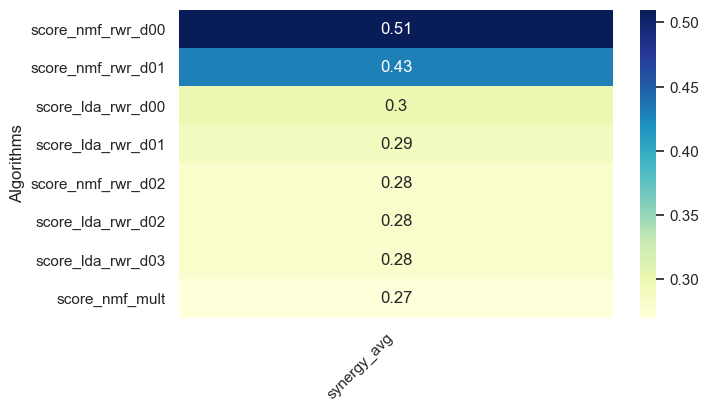

In [29]:
#matrix = np.triu(corr_df)

ax = sns.heatmap(corr_df, cmap="YlGnBu", annot=True)#, mask=matrix)

labels_maps = {'persuasion_scores': 'Persuasive', 'reasonable_scores': 'Reasonable',
 'self_contained_scores': 'Self Contained', 'thesis_scores':'Thesis Indicative', 
  'overall_scores':'Overall'}
labels_x = [item.get_text() for item in ax.get_xticklabels()]
#labels_x = [labels_maps[x] for x in labels_x]

labels_y = [item.get_text() for item in ax.get_yticklabels()]

#labels_y = [labels_maps[x] for x in labels_y]

ax.set_xticklabels(labels_x, rotation=45, ha="right")
ax.set_yticklabels(labels_y)

plt.show()

# 3. Directions

## All data 

In [ ]:
pd.crosstab(data_df['algorithm'], data_df['direction'],margins=True)

In [ ]:
pd.crosstab(data_df['direction'], data_df['synergy'],margins=True).T

In [ ]:
pd.crosstab([data_df['algorithm'], data_df['synergy']], data_df['direction'],margins=True)

## Majority

In [166]:
pd.crosstab(repo_pairs_ann_df['algorithm'], repo_pairs_ann_df['synergy_avg'],margins=True)

synergy_avg,1.0,2.0,3.0,4.0,All
algorithm,,,,,
d00,5,12,7,6,30
d02,8,12,9,1,30
random,20,8,2,0,30
All,33,32,18,7,90


In [167]:
pd.crosstab([repo_pairs_ann_df['algorithm'], repo_pairs_ann_df['synergy_avg']], repo_pairs_ann_df['direction_majority'],margins=True)

direction_majority      0   2  12  21  All
algorithm synergy_avg                     
d00       1.0           4   1   0   0    5
          2.0           4   6   2   0   12
          3.0           0   3   1   3    7
          4.0           0   4   0   2    6
d02       1.0           7   1   0   0    8
          2.0           5   4   2   1   12
          3.0           0   7   0   2    9
          4.0           0   1   0   0    1
random    1.0          15   2   1   2   20
          2.0           6   1   0   1    8
          3.0           0   0   0   2    2
All                    41  30   6  13   90

In [2]:
# plotting 
import matplotlib.pyplot as plt

%matplotlib inline

sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(8,5)}, 
    #style="white" # nicer layout
)

In [14]:
discovery_rate_df = pd.read_csv('../../data/evaluation/manual/discovery_rates.csv')
res_lda_rwr02  = pd.read_csv('../../data/evaluation/stargazing_eval_lda_rwr_d02.csv')

In [15]:
discovery_rate_df.set_index('Unnamed: 0', inplace=True)
res_lda_rwr02.set_index('Unnamed: 1', inplace=True)

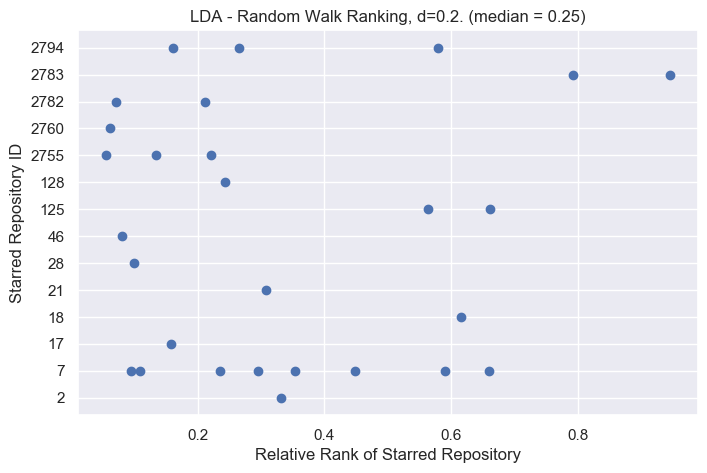

In [16]:
plt.plot(res_lda_rwr02["rank"], res_lda_rwr02.source.astype("str"), 'o', )
plt.title("LDA - Random Walk Ranking, d=0.2. (median = " + np.round(np.median(res_lda_rwr02["rank"]), 2).astype("str") + ")")
plt.xlabel("Relative Rank of Starred Repository")
plt.ylabel("Starred Repository ID")
plt.show()


In [17]:
res_lda_rwr02['rank'].min()

0.05556393244873342

In [18]:
res_lda_rwr02['rank_round'] = round(res_lda_rwr02['rank']*100)


def add_top(row):
    if row['rank_round'] <=20:
        row['Top Ranking']= '0-20'
    elif row['rank_round'] <=30:
        row['Top Ranking']= 30
    elif row['rank_round'] <=40:
        row['Top Ranking']= 40
    elif row['rank_round'] <=50:
        row['Top Ranking']= 50
    elif row['rank_round'] <=60:
        row['Top Ranking']= 60
    elif row['rank_round'] <=70:
        row['Top Ranking']= 70
    elif row['rank_round'] <=80:
        row['Top Ranking']= 80
    elif row['rank_round'] <=90:
        row['Top Ranking']= 90
    else:
        row['Top Ranking']= 100
    return row

res_lda_rwr02 = res_lda_rwr02.apply(add_top, axis=1)

In [19]:
res_lda_rwr02.head()

,source,source.1,target,rank,rank_round,Top Ranking
Unnamed: 1,,,,,,
0,2.0,2.0,9314.0,0.331574,33.0,40
0,7.0,7.0,5907.0,0.094692,9.0,0-20
1,7.0,7.0,10363.0,0.108866,11.0,0-20
2,7.0,7.0,4151.0,0.235977,24.0,30
3,7.0,7.0,2036.0,0.294934,29.0,30


In [20]:
sns.color_palette("mako_r", 1)[0]

(0.20722876, 0.47763224, 0.63711608)

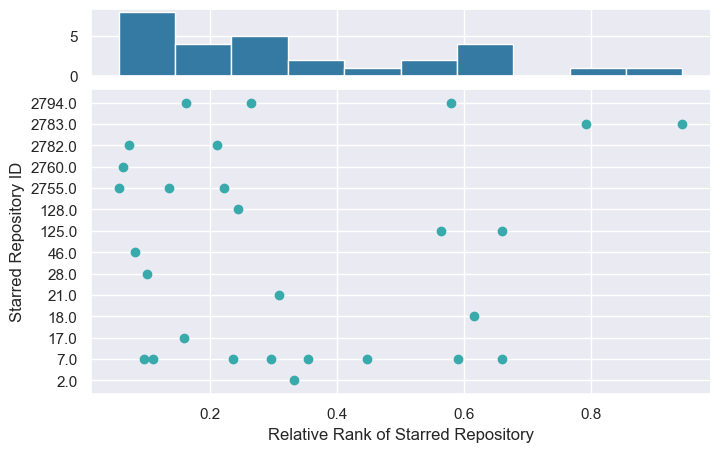

In [21]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

x = res_lda_rwr02['rank']#np.random.randn(1000)
y = res_lda_rwr02['source']#

fig = plt.figure()

gs = GridSpec(5,4)

ax_joint = fig.add_subplot(gs[1:5,0:4])
ax_marg_x = fig.add_subplot(gs[0,0:4])

ax_joint.plot(res_lda_rwr02["rank"], res_lda_rwr02.source.astype("str"), 'o', color=sns.color_palette("mako_r", 5)[1])
ax_marg_x.hist(x, color=sns.color_palette("mako_r", 1)[0])

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)

# Set labels on joint
#ax_joint.set_title("LDA - Random Walk Ranking, d=0.2. (median = " + np.round(np.median(res_lda_rwr02["rank"]), 2).astype("str") + ")")
ax_joint.set_xlabel("Relative Rank of Starred Repository")
ax_joint.set_ylabel("Starred Repository ID")
# Set labels on marginals
#ax_marg_x.set_ylabel('# of Repositories')
plt.show()

In [24]:
discovery_rate_df.algorithm.unique()

array(['score_lda_rwr_d00', 'score_lda_rwr_d01', 'score_lda_rwr_d02',
       'score_lda_rwr_d03', 'score_lda_rwr_d05'], dtype=object)

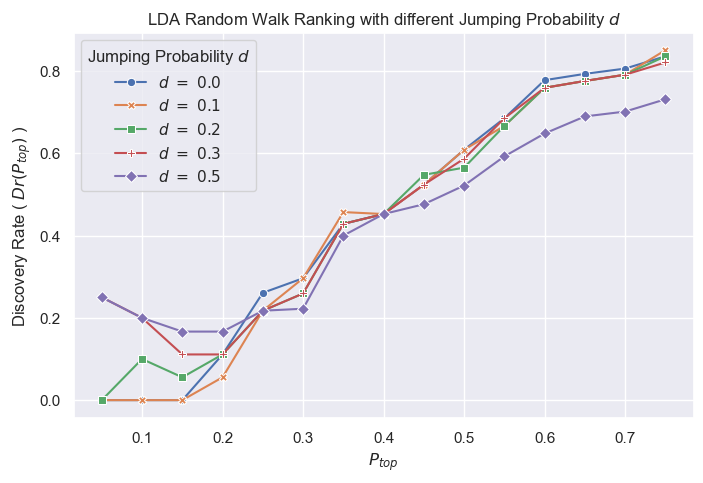

In [26]:
#palette = sns.color_palette("mako_r", 4)
plt.close("all")
ax = sns.lineplot(x="top_p", y="discovery_rate", data=discovery_rate_df, hue="algorithm", style="algorithm", 
                  markers=True, dashes=False)#,palette=palette)
#for algo, algo_df in discovery_rate_df.groupby('algorithm'):ax
ax.set_xlabel(r'$P_{top}$')
ax.set_ylabel(r'Discovery Rate ( $Dr(P_{top})$ )')


# check axes and find which is have legend

plt.legend(title=r'Jumping Probability $d$', loc='best',
           labels=[r'$d~=~0.0$', r'$d~=~0.1$', r'$d~=~0.2$', r'$d~=~0.3$', r'$d~=~0.5$'])   
plt.title(r'LDA Random Walk Ranking with different Jumping Probability $d$')
#ax.set_('d')
plt.show()

In [ ]:
repo_pairs_scores_df.columns

In [ ]:
all_repos = pd.read_csv('../../data/processed/final_repo_english_whatwhy.csv')
len(all_repos)

In [ ]:
len(all_repos.url_readme.unique())

In [ ]:
repo_pairs_scores_df = repo_pairs_scores_df.apply(_get_jaccard_sim, axis=1)

In [ ]:
repo_pairs_scores_df.describe()

In [ ]:
repo_pairs_ann_df

In [121]:


explanation_df = annotations_df[annotations_df.explanation.notnull()]
explanation_df =explanation_df[['a_id', 'user_id', 'repository_pair_id',  'synergy',
       'direction', 'explanation',  'synergy_yn']]

In [122]:
explanation_df.sort_values('repository_pair_id')

,a_id,user_id,repository_pair_id,synergy,direction,explanation,synergy_yn
134,135,12,1,1,0,image generation from text vs. testing wireless security.\r\noperate on different type of information: natural language vs. bit streams,0
240,241,10,1,1,0,"Maybe at some point in the future something like Repo 1 could be used to generate visualizations for the wireless scanning in Repo 2. But this is far too speculative to consider it a real synergy, in my view.",0
135,136,12,2,1,0,visualize program code vs. maintain certificates,0
241,242,10,2,1,0,"I cannot see most of the Readme for Repository 1 in the annotation UI. From what I can gather: Repo1 generates control flow graphs for Java code, Repo2 is implemented in Python.",0
136,137,12,3,1,0,image scraping for some websites vs. word embedding provider,0
...,...,...,...,...,...,...,...
258,259,19,88,4,2,"There are some Repositories who combine Recat and NVD3, so this would be a good idea for python, too.",1
101,102,16,88,4,2,Web applications using Python as backend and React as front end can leverage these libraries for better data visualizations in Python.,1
259,260,19,89,1,0,"Autospec helps you to create RPM´s and pdfcropmargins crops PDF´s, there is no synergy.",0
133,134,20,90,3,12,Add google maps support additionally to STL Files,1


In [123]:
len(explanation_df)

206

In [125]:
explanation_df.to_csv('../../data/cleaned_explanation.csv')